https://www.kaggle.com/datasets/akilesh253/sugarcane-plant-diseases-dataset/data
https://www.kaggle.com/code/dogukantabak/sugarcane-plant-diseases-classification-resnet50

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
INPUT_DATA_PATH = "/content/drive/MyDrive/Diseases_Project/Diseases_v2"
SPLIT_DATA_PATH ="/content/drive/MyDrive/Diseases_Project/Diseases_Split"
folder_path = '/content/drive/My Drive/Diseases_Project'
output_csv_file = "Diseases_labels.csv"
dataset_splits_file = "dataset_splits.csv"
accuracy_loss_file = "train_accuracy_loss.png"
save_model_file = "disease_model.keras"
label_mapping_file = "class_mapping.json"
confusion_matrix_file = "confusion_matrix.png"

IMAGE_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
EPOCHS = 10
DENSE_LAYER = 256

In [ ]:
#@title For Loop Variable
IMAGE_SIZE = [128, 256, 512, 1028]
BATCH_SIZE = [16, 32, 64]
EPOCHS = [10, 30, 50]
DENSE_LAYER = [128, 256, 512]
LEARNING_RATE = [0.0001, 0.001, 0.01]

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_folder_path = os.path.join(SPLIT_DATA_PATH, "train")
val_folder_path = os.path.join(SPLIT_DATA_PATH, "val")
test_folder_path = os.path.join(SPLIT_DATA_PATH, "test")

for image_size in IMAGE_SIZE:
  for batch_size in BATCH_SIZE:
    for epoch in EPOCHS:
      for dense_layer in DENSE_LAYER:
        for learning_rate in LEARNING_RATE:
          sub_folder_path = os.path.join(f"{image_size}x{image_size}_v2", f"BATCH_{batch_size}-EPOCHS_{epoch}-DENSE_{dense_layer}-LEARNING_RATE_{learning_rate}")
          output_csv_path = os.path.join(folder_path, sub_folder_path, output_csv_file)
          dataset_splits_path = os.path.join(folder_path, sub_folder_path, dataset_splits_file)
          accuracy_loss_path = os.path.join(folder_path, sub_folder_path, accuracy_loss_file)
          save_model_path = os.path.join(folder_path, sub_folder_path, save_model_file)
          label_mapping_path = os.path.join(folder_path, sub_folder_path, label_mapping_file)
          confusion_matrix_path = os.path.join(folder_path, sub_folder_path, confusion_matrix_file)

          new_folder = os.path.join(folder_path, sub_folder_path)
          os.makedirs(new_folder, exist_ok=True)

In [ ]:
#@title Fix Variable
import os

SEED = 42
IMG_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
train_folder_path = os.path.join(SPLIT_DATA_PATH, "train")
val_folder_path = os.path.join(SPLIT_DATA_PATH, "val")
test_folder_path = os.path.join(SPLIT_DATA_PATH, "test")

sub_folder_path = os.path.join(f"{IMAGE_SIZE}x{IMAGE_SIZE}_v2", f"BATCH_{BATCH_SIZE}-EPOCHS_{EPOCHS}-DENSE_{DENSE_LAYER}-LEARNING_RATE_{LEARNING_RATE}")

output_csv_path = os.path.join(folder_path, sub_folder_path, output_csv_file)
dataset_splits_path = os.path.join(folder_path, sub_folder_path, dataset_splits_file)
accuracy_loss_path = os.path.join(folder_path, sub_folder_path, accuracy_loss_file)
save_model_path = os.path.join(folder_path, sub_folder_path, save_model_file)
label_mapping_path = os.path.join(folder_path, sub_folder_path, label_mapping_file)
confusion_matrix_path = os.path.join(folder_path, sub_folder_path, confusion_matrix_file)

In [ ]:
new_folder = os.path.join(folder_path, sub_folder_path)
os.makedirs(new_folder, exist_ok=True)
print("Số lượng class:", len(os.listdir(INPUT_DATA_PATH)))
print(os.listdir(INPUT_DATA_PATH))

In [ ]:
#@title Split Folders
# !pip install split-folders
# import splitfolders

# splitfolders.ratio(INPUT_DATA_PATH, output=SPLIT_DATA_PATH, seed=SEED, ratio=(TRAIN_RATIO, VALIDATE_RATIO, TEST_RATIO), group_prefix=None)

In [ ]:
#@title Image Data Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)
# ----------------------------------------

train_generator = train_datagen.flow_from_directory(
    train_folder_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

val_generator = val_test_datagen.flow_from_directory(
    val_folder_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

test_generator = val_test_datagen.flow_from_directory(
    test_folder_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

In [ ]:
#@title Save Class Mapping
import json
def save_class_mapping(train_gen, label_mapping_path):
    # Extract class indices from train_gen
    class_indices = train_gen.class_indices  # {class_name: class_index}

    # Reverse the mapping to create {class_index: class_name}
    label_mapping = {value: key for key, value in class_indices.items()}

    # Save the mapping to a JSON file
    with open(label_mapping_path, "w") as f:
        json.dump(label_mapping, f, indent=4)  # Use indent for better readability

    print(f"Class mapping saved to {label_mapping_path}")
save_class_mapping(test_generator, label_mapping_path)

In [ ]:
#@title Build ResNeT50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

base_model.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(DENSE_LAYER, activation='relu'),
    Dropout(0.5),
    Dense(len(test_generator.class_indices), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.save(save_model_path)

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

In [ ]:
#@title Plot Training History
import matplotlib.pyplot as plt

def plot_and_save_training_history(history, accuracy_loss_file):
    # Plot Accuracy
    plt.figure(figsize=(10, 5))  # Create a figure with defined size
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot in the first position
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)  # Plot in the second position
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(accuracy_loss_file)  # Save accuracy plot
    plt.show()
    print(f"Accuracy plot saved as {accuracy_loss_file}")
    plt.close()  # Close the figure to free memory
plot_and_save_training_history(history, accuracy_loss_path)

In [ ]:
#@title Plot Model Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_model_confusion_matrix(model, test_gen, confusion_matrix_file):
    """
    Generates predictions on test data, computes the confusion matrix,
    and displays a heatmap.

    Parameters:
    - model: Trained Keras model.
    - test_gen: Keras test data generator (with shuffle=False).

    Returns:
    - y_true, y_pred: Lists of true and predicted class indices.
    """
    y_true = []
    y_pred = []

    # Loop through the test generator to collect predictions
    for x_batch, y_batch in test_gen:
        preds = model.predict(x_batch, verbose=0)
        y_true.extend(np.argmax(y_batch, axis=1))     # Convert one-hot to class indices
        y_pred.extend(np.argmax(preds, axis=1))

        # Stop when the full test set is covered
        if len(y_true) >= test_gen.samples:
            break

    # Truncate to match number of samples exactly
    y_true = y_true[:test_gen.samples]
    y_pred = y_pred[:test_gen.samples]

    # Get class label names
    class_labels = list(test_gen.class_indices.keys())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix (Unnormalized)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig(confusion_matrix_file)  # Save accuracy plot
    plt.show()
    plt.close()  # Close the figure to free memory
    return y_true, y_pred
y_true, y_pred = plot_model_confusion_matrix(model, test_gen, confusion_matrix_path)

In [3]:
#@title Build ResNeT50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(128, 128, 3))

base_model.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

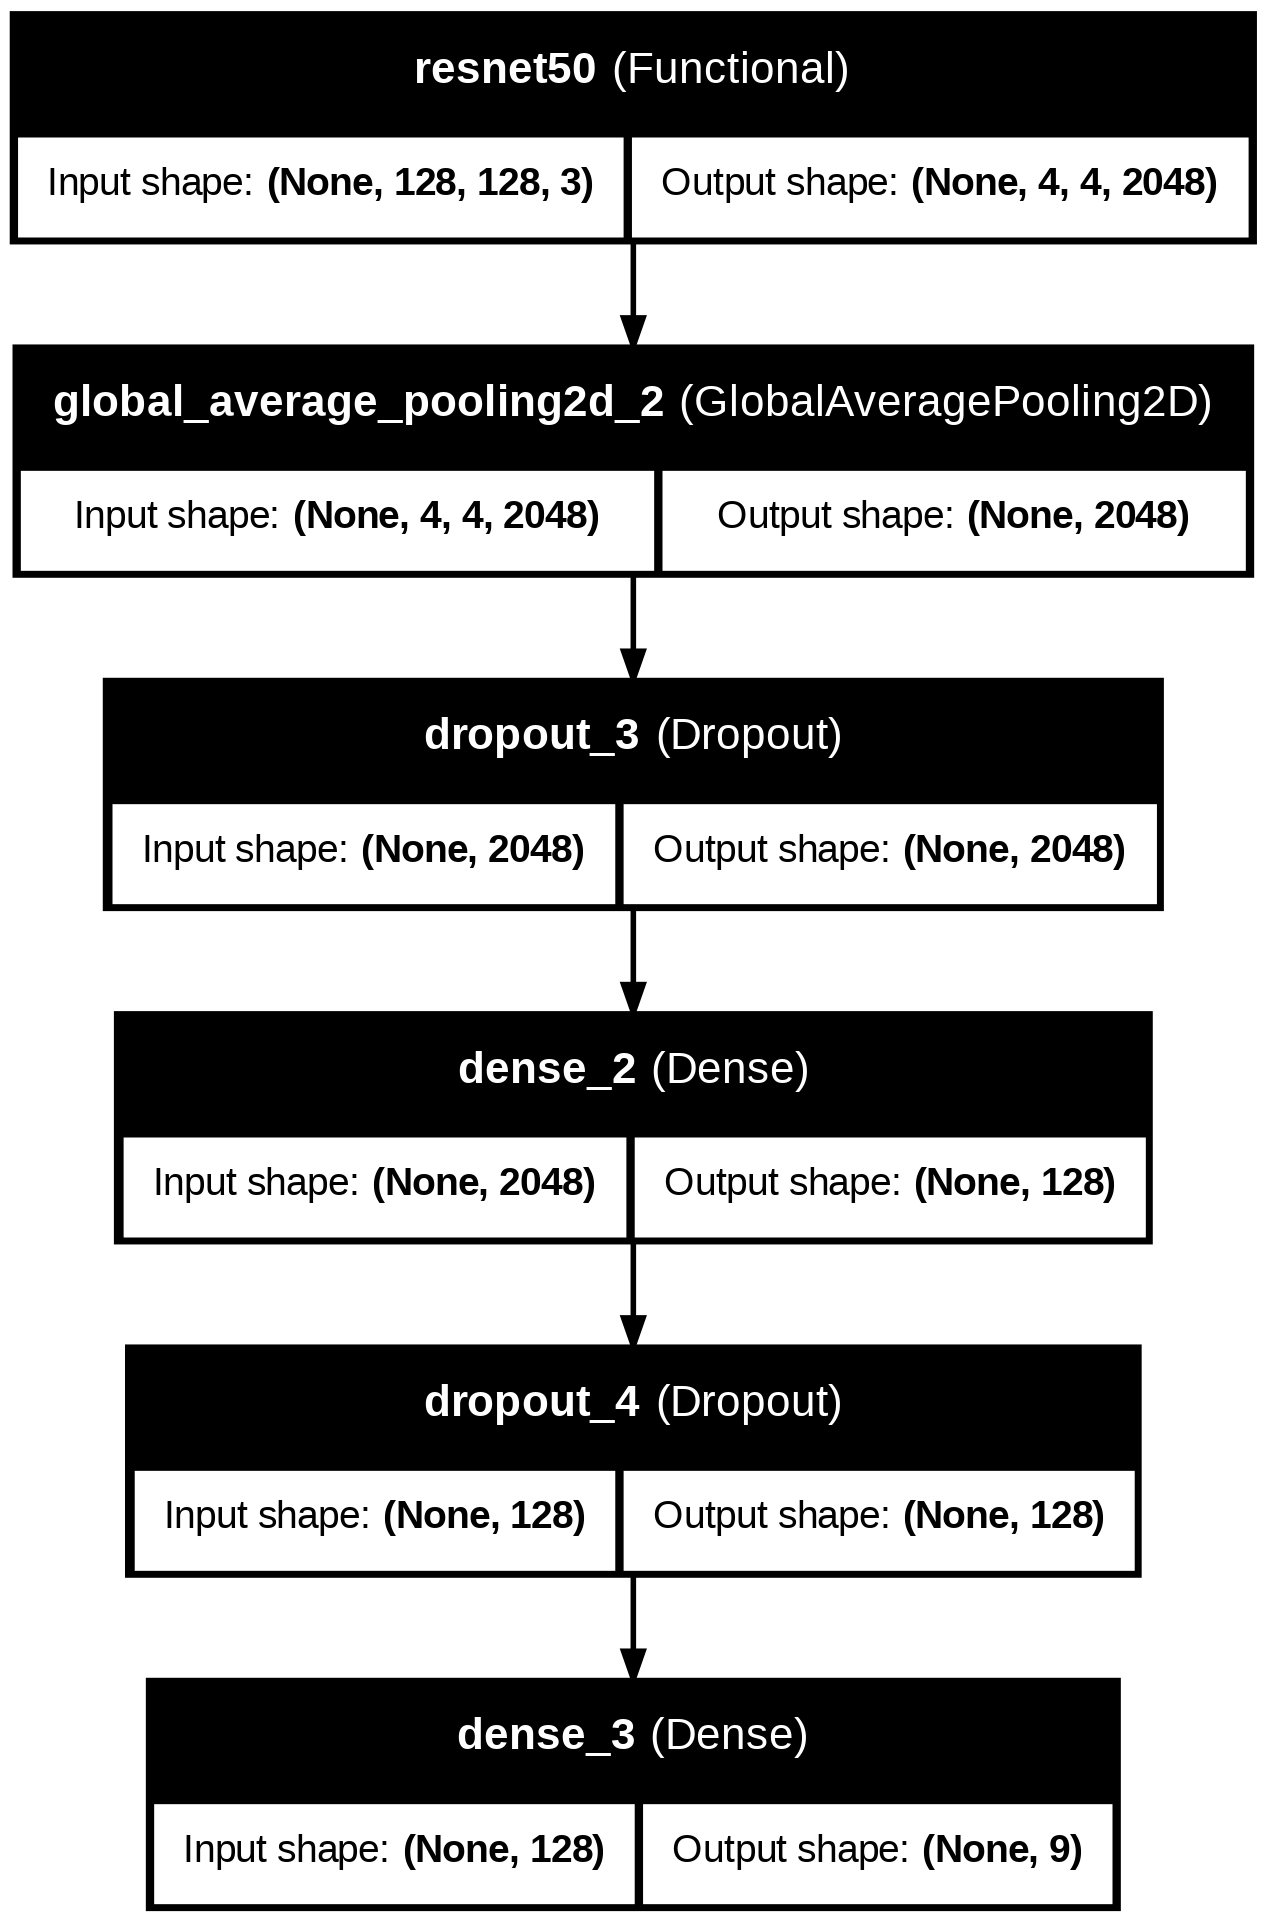

In [5]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='resnet50_model.png', show_shapes=True, show_layer_names=True)